In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The GP Code (1D)

### Covariance Function

RBF Kernel: $k(x_i,x_j) = \sigma^2 exp \left(- \frac{(x_i-x_j)^2}{2 l^2} \right)$

In [2]:
def k_RBF(xi: np.array ,xj: np.array, length_scale: float, variance: float) -> np.array:
    return variance * np.exp(- (xi[:,None] - xj[None,:])**2 / (2 * length_scale**2) )

### Covariance Matrix

$\Sigma_{ij} = k(x_i,x_j)$

### Prediction

with $\Sigma = \begin{pmatrix} K & K_* \\ K_*^T & K_{**} \\ \end{pmatrix}$

prediction mean: $\mu_t = K_*^T K^{-1} Y$

prediction covariances: $\Sigma_t = K_{**} - K_*^T K^{-1} K_*$

In [3]:
def calc_gp(x_t: np.array, X: np.array, Y: np.array, length_scale: float, variance: float) -> np.array:

    n = len(X)

    X_new = np.concatenate((X, x_t))

    Sigma = k_RBF(X_new, X_new, length_scale, variance)

    K = Sigma[:n,:n]
    Kstar = Sigma[:n,n:]
    Kstarstar = Sigma[n:,n:]
    
    Kinv = np.linalg.inv(K)
    
    KstarTKinv = np.matmul(Kstar.T,Kinv)
    mu_t = np.matmul(KstarTKinv,Y)
    Sigma_t = Kstarstar - np.matmul(KstarTKinv,Kstar)
    var_t = np.diag(Sigma_t)

    return [mu_t, var_t]

---

# Generate Data

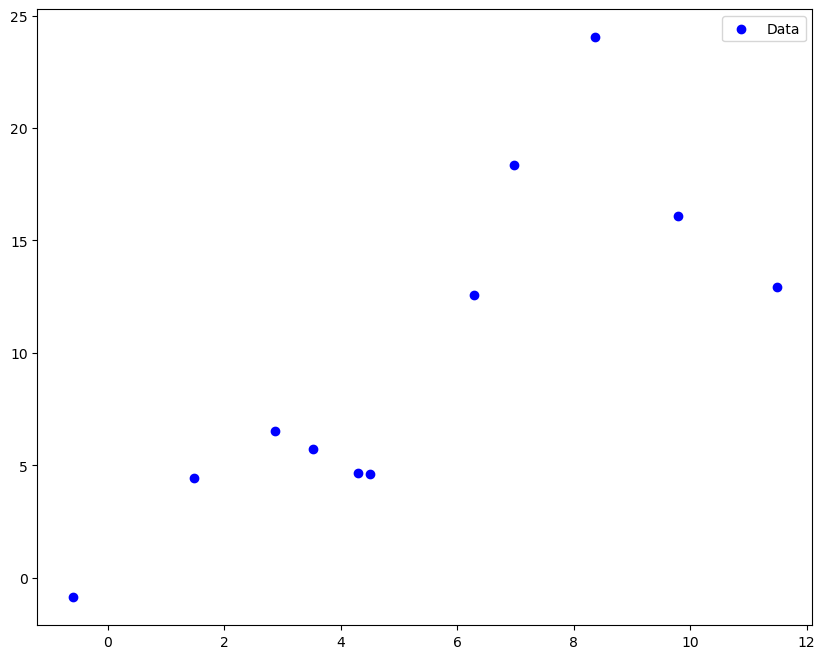

In [4]:
# generate data
x_min, x_max, x_steps = [0,10,11]

X = np.linspace(x_min,x_max,x_steps) + np.random.normal(0,(x_max-x_min)/x_steps,x_steps)
Y = X*np.sin(X) + 2*X

plt.figure(figsize=(10,8))
plt.scatter(X,Y,c="blue",label="Data")
plt.legend()

# Calculate GP

In [12]:
# calculate gp
parameter_l, parameter_var = [1.2,3]

x_pred = np.arange(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),0.2)
y_pred, y_var = calc_gp(x_pred,X,Y,parameter_l,parameter_var)

# plotting the actual function for cross check
X_truth = np.linspace(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),100)
Y_truth = X_truth*np.sin(X_truth) + 2*X_truth

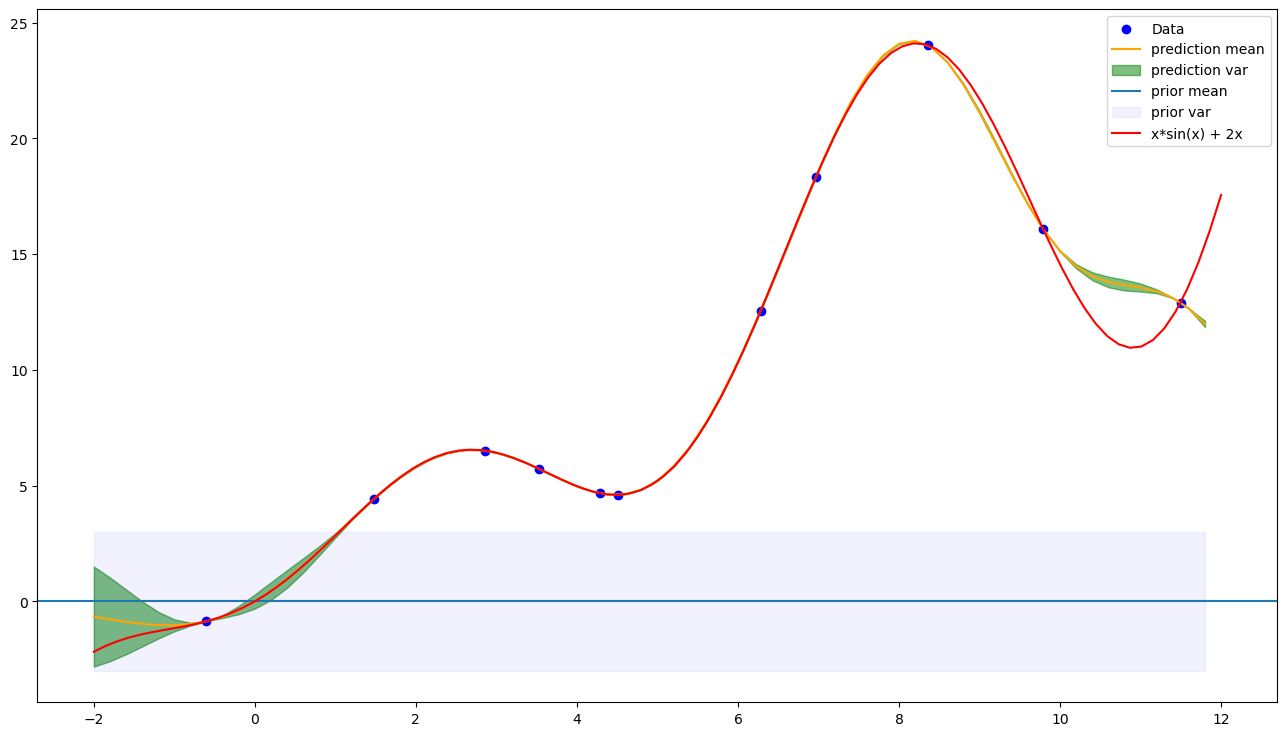

In [13]:
# plot result
plt.figure(figsize=(16,9))

# data
plt.scatter(X,Y,c="blue",label="Data")

# prediction
plt.plot(x_pred,y_pred,c="orange", label="prediction mean")
plt.fill_between(x_pred,
                 y_pred+y_var,
                 y_pred-y_var,
                 color="green",alpha=0.5,label="prediction var")

# prior
plt.axhline(0,label="prior mean")
plt.fill_between([np.min(x_pred),np.max(x_pred)],
                 0+parameter_var,
                 0-parameter_var,
                 color="blue",alpha=0.05,label="prior var")

# true function from which the data was sampled
plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")

plt.legend()
# plt.savefig("gp_figure.png",bbox_inches='tight', pad_inches=0)

# Same Thing Using Scikit Learn

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [8]:
gp = GaussianProcessRegressor(kernel=RBF())

# uses fit on the same data as above, defined in X, Y
gp.fit(X.reshape(-1, 1),Y)

# prediction with variance
y_gp_pred, y_gp_pred_var = gp.predict(x_pred.reshape(-1, 1),return_std=True)

print(gp.kernel_)

RBF(length_scale=1.47)


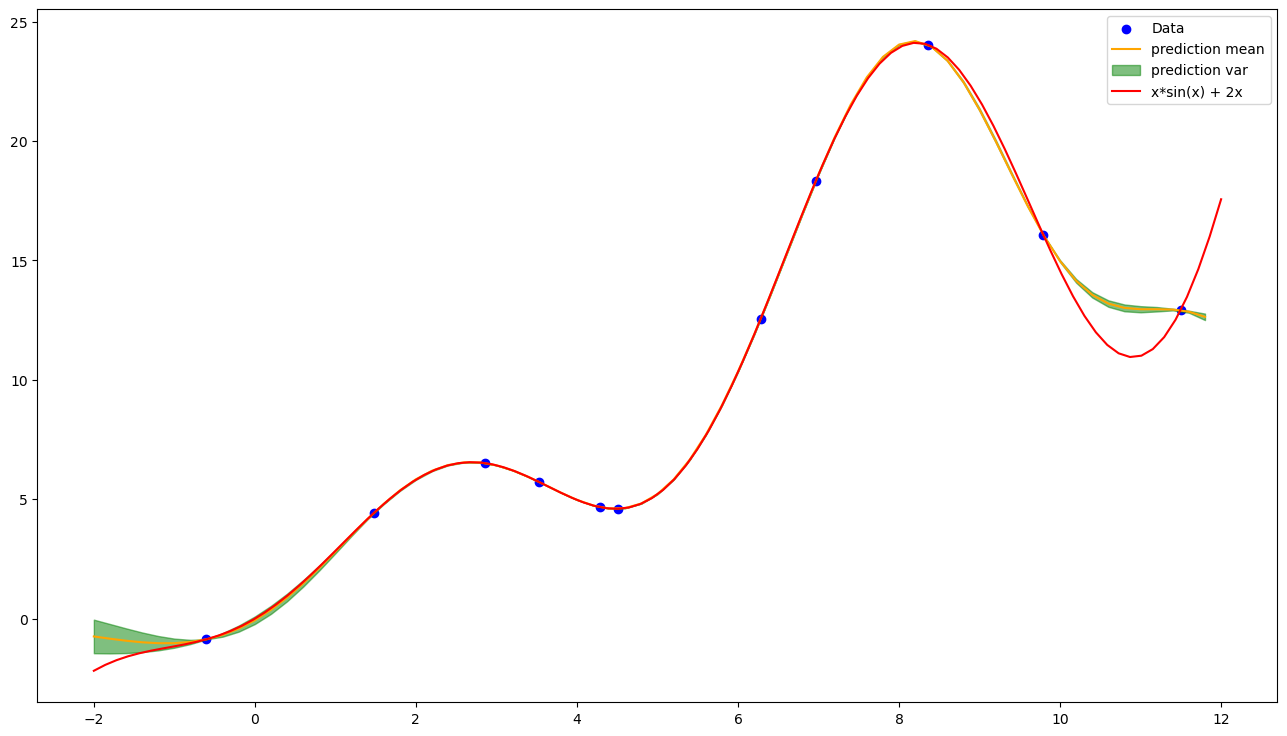

In [9]:
# plot result
plt.figure(figsize=(16,9))

# data
plt.scatter(X,Y,c="blue",label="Data")

# prediction
plt.plot(x_pred,y_gp_pred,c="orange", label="prediction mean")
plt.fill_between(x_pred,
                 y_gp_pred+y_gp_pred_var,
                 y_gp_pred-y_gp_pred_var,
                 color="green",alpha=0.5,label="prediction var")


# true function from which the data was sampled
plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")

plt.legend()
# plt.savefig("gp_figure_sklearn.png",bbox_inches='tight', pad_inches=0)